In [79]:
import pandas as pd
import numpy as np
import seaborn as sns # hack---doing this sets the pandas plots to use seaborn styles!
from pyproj import Proj
from prettypandas import PrettyPandas
from collections import Counter
import ast
from geopy.geocoders import GoogleV3
from geopy.exc import GeocoderTimedOut
import geojson

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 500)

In [73]:
pluto = pd.read_csv('nyc_pluto.csv', index_col=0)

/Users/Honors/anaconda/envs/nyc-buildings/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,20,22,23,24,25,66,67,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Ownership

Who owns the buildings in New York City? This is actually a very difficult question to answer. The Roman Catholic Church, for example, probably owns a formidable number of buildings in the city, but as they tend to be owned in name by individuals or sub-units of the church at large, precisely how much they own is hard to answer. There are also plenty of opaque development groups and investment vehicles around playing the real estate market shell game, making it all the more challenging to follow who owns what and further muddying the picture.

Still, the public record should be able to tell us some very interesting things. To start with, using the `PLUTO` dataset&mdash;a public archival record on everything that the city government knows about every building in New York City&mdash;who is the most enumerate landowner in New York City?

Somewhat obviously the single largest property-holder in New York City is New York City itself, with various agencies of the city government taking all but one of the top 10 and most of the top 50 slots. The one exception is the sixth biggest property-owner, `OWNER / AGENT`&mdash;a mildly questionable instance of indeterminate ownership in the public record. There is also an option for the 33 propreties in the city for whom an owner is apparently simply `UNKNOWN`.

However, the public record of public asset ownership is a little haphazard. For instance in additional to dedicated points for each of the individual city agenices there are several different variations on "the City of New York" (`CITY OF NEW YORK`, `THE CITY OF NEW YORK`, etc.), and a similar situation exists for federal and state agencies, which are listed either individually or as part of the `UNITED STATES GOVERNMENT` or even `THE PEOPLE OF THE STATE OF NEW YORK`. So to explore the raw data yourself, go here.

It's easier for us to examine private entity data. A [Q&A published in *The New York Times* in 1994](http://www.nytimes.com/1994/10/16/nyregion/fyi-531286.html) fingers Columbia Univesity, NYU, Trinity Church, and a handful of developers as the biggest in terms of private addresses held. What does the picture look like today? Filtering out public services, here is what the public record has to say about the 20 private owners with the largest number of buildings:

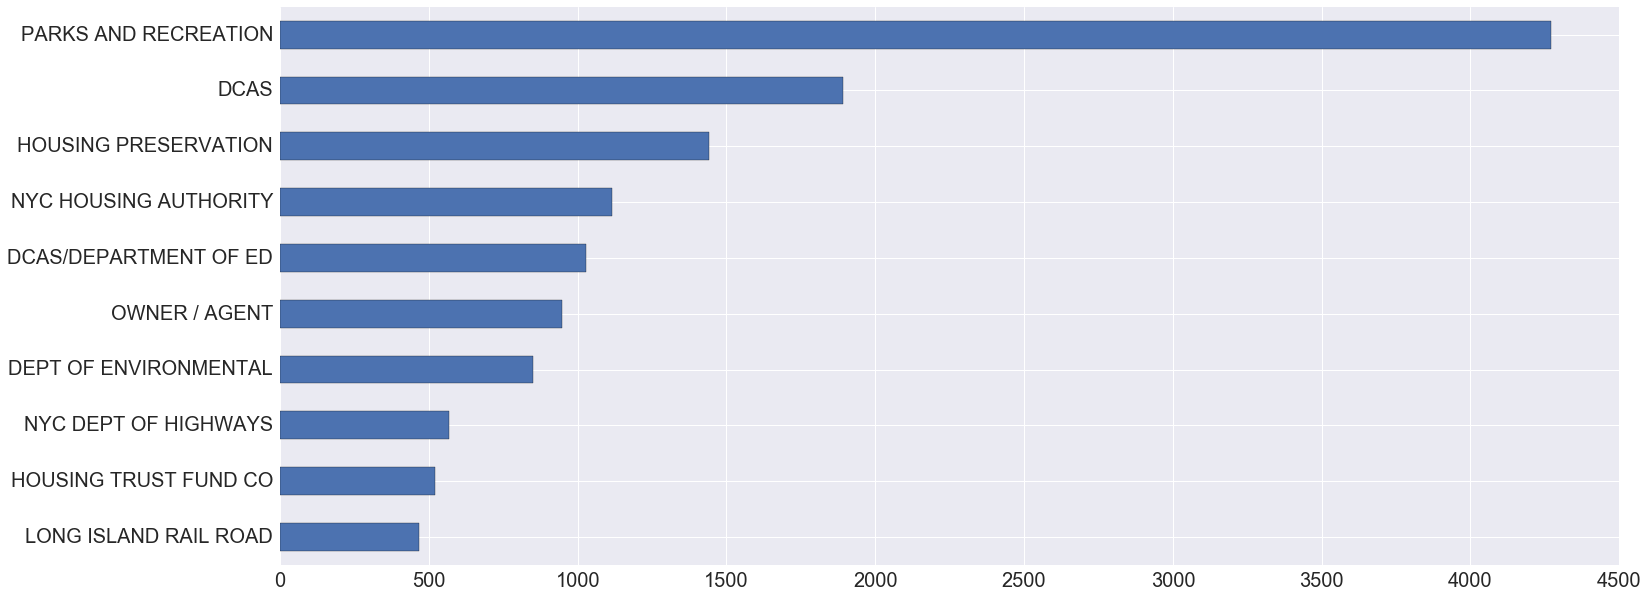

In [94]:
pluto['OwnerName'].value_counts()[:10].sort_values(ascending=True).plot(kind='barh', figsize=(24, 10), fontsize=20)

In [97]:
# pd.set_option('display.height', 500)
# pluto['OwnerName'].value_counts()[:500]

In [ ]:
# pluto['OwnerName'].value_counts()[:50]

In [67]:
# pluto['OwnerName'].value_counts()[51:100]

In [75]:
# Create the DataFrame.

mepl_names = [
    'TRUSTEES OF COLUMBIA',
    'NEW YORK UNIVERSITY',
    'DEUTSCHE BANK NATIONA',
    'PENRITH URF LLC',
    'NEHEMIAH HOUSING DEVE',
    'NORTHEASTERN CONFEREN',
    'MHANY 2015 HOUSING DE',
    'U.S. BANK NATIONAL AS',                                  
    'CONSOLIDATED EDISON C',
    'SILVERSHORE PROPERTIE',
    'THE TRUSTEES OF COLUM',
    'IMPACCT HOUSING DEVEL',
    'ROMAN CATHOLIC CHURCH',
    'WELLS FARGO BANK, N.A',
    'MAGUIRE AVENUE REALTY',
    'NEW YORK GARDEN TRUST',
    'CASA MASON CORP',
    'CLINTON GRAHAM',
    'MG RICHMOND LLC',
    'HPENY HOUSING DEVELOP',
    'PROL PROPERTIES CORPO'
]
# private_owners = pluto['OwnerName'].value_counts().ix[private_raw_names]
mepl_name_map = {'TRUSTEES OF COLUMBIA': 'Trustees of Columbia',
            'THE TRUSTEES OF COLUM': 'Columbia University 2',
            'NEW YORK UNIVERSITY': 'New York University',
            'DEUTSCHE BANK NATIONA': 'Duestche Bank National Trust',
            'PENRITH URF LLC': 'Penrith Urf LLC',
            'MHANY 2015 HOUSING DE': 'Mutual Housing Association Of New York',
            'NEHEMIAH HOUSING DEVE': 'Nehemaih Housing Development',
            'NORTHEASTERN CONFEREN': 'Northeastern Conference of Seventh-Day Adventists',
            'U.S. BANK NATIONAL AS': 'U.S. Bank National Association',
            'CONSOLIDATED EDISON C': 'Consolidated Edison Company',
            'SILVERSHORE PROPERTIE': 'Silvershore Properties',
            'IMPACCT HOUSING DEVEL': 'Impacct Housing Development Corporation',
            'CASA MASON CORP': 'Casa Mason Corporation',
            'MG RICHMOND LLC': 'MG Richmond LLC',
            'HPENY HOUSING DEVELOP': 'Hpeny Housing Development Corporation',
            'PROL PROPERTIES CORPO': 'Prol Properties Corporation'
                }

# private_owners.index = [map_name(name, mepl_name_map) for name in private_owners.index]
# private_owners = private_owners.groupby(private_owners.index).sum().sort_values(ascending=False)
# private_owners.index.name = 'Owner'
# private_owners.name = 'Addresses'
# private_owners = pd.DataFrame({'Owner': private_owners.index, 'Addresses': private_owners.values}, index=list(range(1, 12)))
# private_owners = private_owners[['Owner', 'Addresses']]
# private_owners.index.name = 'Rank'

In [76]:
"""
Helper function that attempts to map a raw name to a processed name using the given _map.
Map is expected to be a dictionary of raw_name:processed_name pairs.
Will return the raw name is title case if an equivalent is not found.
"""
def map_name(raw_name, _map):
    if raw_name in _map.keys():
        return _map[raw_name]
    else:
        return raw_name.title()

projstr = '+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs'

pnyc = Proj(projstr,
            preserve_units=True
           )

geolocator = GoogleV3(api_key='...') # Insert your own!

"""
Maps potential x and y coordinates stored in the state grid metric into global coordinates.
If this fails, will return the result of a Google geocoding query instead.
"""
def map_coordinates(x, y): # , address):
    ret = pnyc(x, y, inverse=True)
    if ret[0] > -70 or ret[0] < -75 or ret[1] < 38 or ret[1] > 44:
        # Then the direct geocoding failed.
        return 0, 0
#         # As a backup, let's try geocoding using the Google API.
#         try:
#             ret = geolocator.geocode('{0}, NEW YORK'.format(address))
#             lat, long = ret.latitude, ret.longitude
#         except GeocoderTimedOut:
#             lat, long = 0, 0
#         return (lat, long)
    else:
        return ret
        
        
"""
Given the raw list of names and a dictionary of raw_name:mapped_name pairs, creates a pd.Series containing
the mapped names as the index and a string-literal store of the list of coordinates as the values.
"""
def generate_df(dataset, raw_names, _map, agg_name, agg_func):
    dat = pd.DataFrame(index=range(1, len(raw_names) + 1))
    dat['Owner'] = [map_name(raw_name, _map) for raw_name in raw_names]
    dat['Places'] = ''
    dat[agg_name] = None
    for rank, owner in zip(range(1, len(raw_names) + 1), raw_names):
        records = dataset[dataset['OwnerName'] == owner]
        coordinates = records.apply(lambda x: map_coordinates(x['XCoord'], x['YCoord']), axis='columns')
        # coordinates = records.apply(lambda x: map_coordinates(x['XCoord'], x['YCoord'], x['Address']), axis='columns')
        coordinate_dict = {a:c for a, c in zip(records['Address'], coordinates)}
        dat.set_value(rank, 'Places', coordinate_dict)
        dat.set_value(rank, agg_name, agg_func(records))
    return dat

In [77]:
# Combine the Columbia entries.
mepl = generate_df(pluto, mepl_names, mepl_name_map, 'Addresses', len)
mepl.set_value(1, 'Addresses', mepl['Addresses'][1] + mepl['Addresses'][11])
mepl.set_value(1, 'Places', {**mepl['Places'][1], **mepl['Places'][11]})
mepl.drop(11, inplace=True)
mepl

,Owner,Places,Addresses
1,Trustees of Columbia,"{'503 WEST 121 STREET': (-73.9591794728358, 40...",206
2,New York University,"{'543 LA GUARDIA PLACE': (-73.99801921153899, ...",95
3,Duestche Bank National Trust,"{'11 EAST 129 STREET': (-73.93955097643386, 40...",83
4,Penrith Urf LLC,"{'29 LINCOLN PLACE': (-73.97858128441864, 40.6...",82
5,Nehemaih Housing Development,"{'703 VANDALIA AVENUE': (0, 0), '717 VANDALIA ...",80
6,Northeastern Conference of Seventh-Day Adventists,"{'420 TARGEE STREET': (-74.08503875733902, 40....",79
7,Mutual Housing Association Of New York,"{'182 COOPER STREET': (-73.90626279200201, 40....",78
8,U.S. Bank National Association,"{'166 MANILA AVENUE': (-74.11035080584813, 40....",76
9,Consolidated Edison Company,"{'JEWETT AVENUE': (0, 0), '43-82 VERNON BOULEV...",74
10,Silvershore Properties,"{'167 WAVERLY AVENUE': (-73.96748411281014, 40...",64


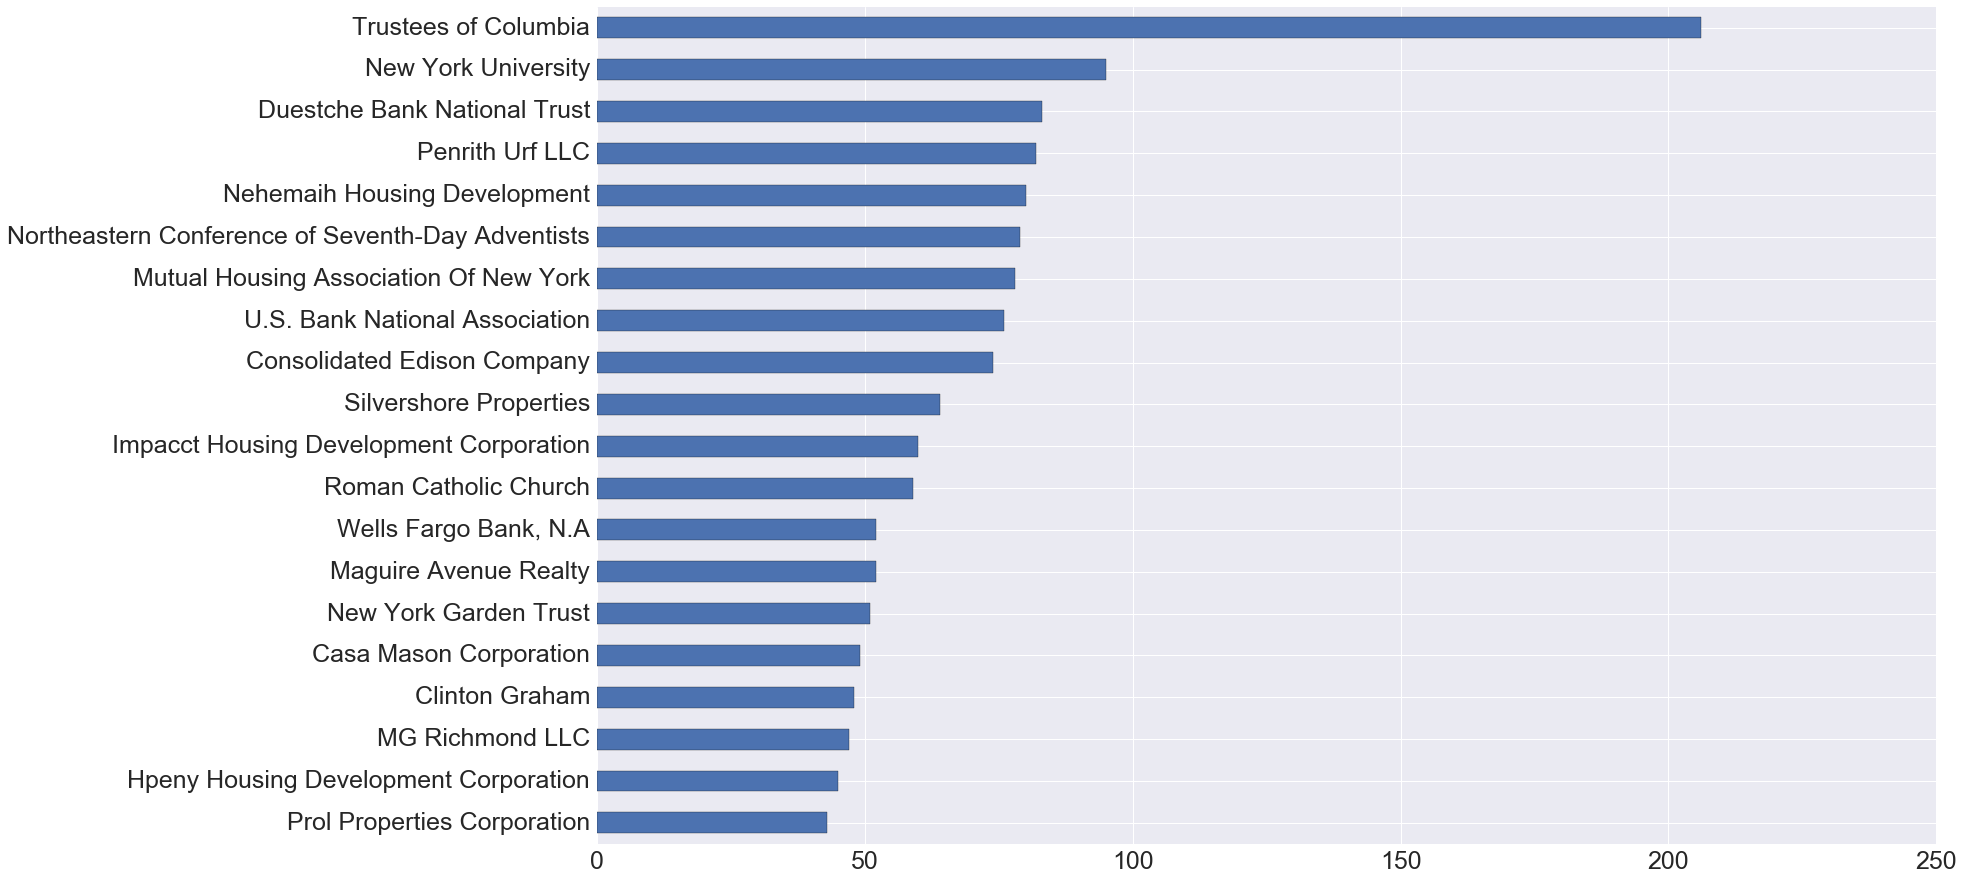

In [117]:
s = mepl.set_index('Owner')['Addresses']
s.index.name = ""
s.sort_values().plot(kind='barh', figsize=(24, 15), fontsize=25, legend=False)

In [46]:
PrettyPandas(mepl[['Owner', 'Addresses']])

**Columbia University is the runaway winner with over 200 properties**. NYU comes in distant second place with 95 addresses, followed by the shady Duestche Bank National Trust (on which almost nothing can be found online, signs pointing to a foreclosure clearing house). Columbia's count is almost triple the 72 addresses allotted to the New York Public Library, for the purposes of comparison.

The rest are an very interesting blend of large utility companies, church groups, private brokerage firms, affordable housing corporations and non-profits, and, further down the line, private investors. 17th-most-enumerate real estate owner Clinton Graham (not shown here), for instance, has a very interesting story, covered by WNYC, behind [his consolidation of properties in Jamacia, Queens](http://www.wnyc.org/story/79636-huge-rezoning-planned-for-jamaica-queens/), while the *Daily News* in 2012 wrote the Spring Creek Nehemaih housing development project up as [an affordable housing success story](http://www.nydailynews.com/life-style/real-estate/spring-creek-nehemiah-affordable-housing-success-story-east-new-york-article-1.1123089).

Why aren't there more, or indeed, almost any, large corporations on the listing? Because even though many companies call New York City their home, either or both in workforce and in headquarters, they own very little of the land they use. Companies strongly prefer renting or leasing their space instead. Wells Fargo is seemingly the largest casually recognizable corporate landowner in New York City&mdash;yet it owns just 42 locations, a far cry from the hundred-fold branches that it operates.

In [13]:
ownership_counts = Counter(pluto['OwnerName'].value_counts().values)

In [14]:
ownership_counts[1] / len(pluto)

0.7891900070413929

In [15]:
141657811/106957002

1.3244370013288143

Still, if nothing else, the data points to a more heterogeneous ownership situation than I had expected. **Almost four-fifths of addresses in New York City are owned by organizations or individuals who own no other property**.

Here's a Gist with the top 500, if you're curious.

How does the picture change we look at square footage? That is, according to public record, who is the largest landowner in New York City?

This time let's first peek at the top ten:

In [16]:
ownership_footage = pluto.groupby(['OwnerName'])['BldgArea'].sum().sort_values(ascending=False)

In [17]:
PrettyPandas(ownership_footage[:11][[0,1,2,3,4,5,6,7,9,10]], precision=10)

Once again city government is a clear winner, with the New York City Housing Authority and the Department of Education being the only entities to own nine digits of square footage in New York City. Interestingly, using these rankings as a proxy for city services, this means that there is 30% more affordable housing than public school to the city.

`Owner / Agent` again ranks alarmingly far up the list, earning a promotion to technical fourth largest landowner.

If we combine "United States Of America" with all of the US Government sub-entities in the dataset&mdash;the National Park Service, USPS, etc.&mdash;it is probably the third largest landowner in the city. The National Park Service on its own is fourth largest.

Filtering down to private entities once more:

In [49]:
ownership_footage[50:]

OwnerName
BPP PCV OWNER LLC        3122165.0
FORDHAM UNIVERSITY       3083387.0
AMALGAMATED WARBASSE     3059938.0
DHS                      2905772.0
SL GREEN REALTY CORP.    2888021.0
LINDSAY PARK HGS CORP    2851162.0
ESRT EMPIRE STATE BUI    2812739.0
PARKCHESTER NORTH CON    2811892.0
200 PARK, L.P.           2768775.0
SOCIETY OF THE NY HOS    2762303.0
MONTEFIORE MEDICAL CE    2757633.0
GOVERNORS ISLAND CORP    2733403.0
KORPENN LLC              2703780.0
BROOKLYN KINGS PLAZA     2668590.0
DORMITORY AUTHORITY O    2622584.0
1221 AVENUE HOLDINGS     2508386.0
PGREF I 1633 BROADWAY    2438059.0
UNITED NATIONS           2435490.0
19-20 BUSH TERMINAL O    2411605.0
THE CITY OF NEW YORK/    2402257.0
BATTERY PARK CITY AUT    2365621.0
388 REALTY OWNER LLC     2354289.0
YILDIZ HOLDING A.S.      2342061.0
USPS                     2302499.0
WFP TOWER B CO LP        2267925.0
ONE BRYANT PARK          2245112.0
ESPLANADE GARDENS INC    2244377.0
NYC DEPT OF EDUCATION    2241518.0
AMERICAN E

In [54]:
lpl_names = ['RIVERBAY CORPORATION',
              'BPP ST OWNER LLC',
              'NEW YORK UNIVERSITY',
              'STARRETT CITY, INC.',
              'PARKCHESTER SOUTH CON',
              'TRUSTEES OF COLUMBIA',
              'ROCHDALE VILLAGE INC',
              'ST JOHN S UNIVERSITY',
              'RCPI HOLDCO LCC',
              'PRESBYTERIAN HSP CITY',
              'THE TRUSTEES OF COLUM',
              'NORTH SHORE TOWERS AP',
              'NEWTON STREET CORP',
              'MOUNT SINAI HOSPITAL',
              'NEW YORK CONVENTION C',
              '1-10 BUSH TERMINAL OW',
              'BPP PCV OWNER LLC',
              'FORDHAM UNIVERSITY',
              'AMALGAMATED WARBASSE',
              'SL GREEN REALTY CORP.'
#               'NEW WATER STREET CORP',
#               'NEW YORK CONVENTION C',
#               'MOUNT SINAI HOSPITAL',
#               '1-10 BUSH TERMINAL OW',
#               'SL GREEN REALTY CORP.',
#               'QUEENS FRESH MEADOWS',
#               'PCV ST-DIL LLC',
#               'FORDHAM UNIVERSITY',
              # 'AMALGAMATED WARBASSE',
              # 'ESRT EMPIRE STATE BUI',
              # '200 PARK, L.P.',
              # 'SOCIETY OF THE NY HOS'
             ]

lpl_name_map = {'NORTH SHORE TOWERS AP': 'North Shore Towers Apartments',
              'PARKCHESTER SOUTH CON': 'Parkchester South Condominiums',
              'TRINITY HUDSON HOLDIN': 'Trinity Hudson Holdings',
              'PARKCHESTER SOUTH CON': 'Parkchester South Condominiums',
              'PRESBYTERIAN HSP CITY': 'New York-Presbyterian Hospital',
              'NEW WATER STREET CORP': 'New Water Street Corporation',
              'NEW YORK CONVENTION C': 'New York Convention Center Corporation',
              'THE TRUSTEES OF COLUM': 'Trustees Of Columbia',
              '1-10 BUSH TERMINAL OW': '1-10 Bush Terminal Owner LP',
              'SL GREEN REALTY CORP.': 'SL Green Realty Corporation',
              'AMALGAMATED WARBASSE': 'Amalgamated Warbasse Houses',
              'ESRT EMPIRE STATE BUI': 'Empire Station Building Realty Trust',
              'SOCIETY OF THE NY HOS': 'Society of the New York Hospital',
              'ST-DIL LLC': 'ST-DIL LLC',
              'PCV ST-DIL LLC': 'PCVST-DIL LLC',
                'BPP ST OWNER LLC': 'BPP ST Owner LLC',
              'ST JOHN S UNIVERSITY': 'St. John\'s University',
                'NORTH SHORE TOWERS AP': 'North Shore Towers Apartments',
                'AMALGAMATED WARBASSE': 'Amalgamated Warbasse Houses',
                'SL GREEN REALTY CORP.': 'SL Green Realty Corporation'
              # 'STARRETT CITY, INC.': 'Starrett City Incorporated'
             }

In [56]:
lpl = generate_df(pluto, lpl_names, lpl_name_map, 'Square Footage', lambda x: sum(x['BldgArea']))
lpl.set_value(6, 'Square Footage', lpl['Square Footage'][6] + lpl['Square Footage'][11])
lpl.set_value(6, 'Places', {**lpl['Places'][6], **lpl['Places'][11]})
lpl.drop(11, inplace=True)
lpl.sort_values('Square Footage', inplace=True, ascending=False)
lpl

,Owner,Places,Square Footage
1,Riverbay Corporation,"{'2051 BARTOW AVENUE': (-73.82878988234862, 40...",2.20427e+07
6,Trustees Of Columbia,"{'503 WEST 121 STREET': (-73.9591794728358, 40...",1.15953e+07
3,New York University,"{'543 LA GUARDIA PLACE': (-73.99801921153899, ...",1.08997e+07
2,BPP ST Owner LLC,"{'240 1 AVENUE': (-73.97789635675532, 40.73172...",8.94218e+06
4,"Starrett City, Inc.",{'1155 PENNSYLVANIA AVENUE': (-73.882819201883...,8.54467e+06
5,Parkchester South Condominiums,{'11 HUGH J GRANT CIRCLE': (-73.86140292912916...,7.12678e+06
7,Rochdale Village Inc,"{'132-11 BEDELL STREET': (-73.76967866262073, ...",6.99684e+06
8,St. John's University,"{'8150A UTOPIA PARKWAY': (-73.79454494581657, ...",4.68744e+06
9,Rcpi Holdco Lcc,{'1260 AVENUE OF THE AMER': (-73.9785874060273...,4.63219e+06
10,New York-Presbyterian Hospital,{'180 FT WASHINGTON AVENUE': (-73.941636229523...,4.58458e+06


In [57]:
PrettyPandas(lpl[['Owner', 'Square Footage']], precision=10)

Riverbay Corporation, the largest private landowner in New York City, earns that title by virtue of its management of [Co-Op City](https://en.wikipedia.org/wiki/Co-op_City,_Bronx), easily the largest of the many private real estate development complexes on the list (so big, in fact, that were it its own municipality it would be the 10th largest city in the state!). The holding company for [Stuyvesant Town](https://en.wikipedia.org/wiki/Stuyvesant_Town%E2%80%93Peter_Cooper_Village) (`BPP ST OWNER LLC` and `Pcv St-Dil Llc `, respectively) also appear on the list, as do a variety of other housing co-op companies.

While it's [NYU's grand expansion plans which are causing a stir in the city](http://ny.curbed.com/nyu-expansion), number-two landowner Columbia University&mdash;located after all in the much quieter environs of upper Manhattan&mdash;absolutely crushes Big Purple in total holdings. St. John's University also makes an appearance (and Fordham University is the 20th entry in the list).

The holding companies for a few of the largest of local landmarks&mdash;[Rockefeller Center](https://en.wikipedia.org/wiki/Rockefeller_Center) (Rcpi Holdco Lcc) and [The Empire State Building](https://en.wikipedia.org/wiki/Empire State Building), for instance&mdash;also rank highly, as do a couple large hospital systems, Sl Green Realty Corporation, a commercial office space broker, and 1-10 Bush Terminal Owner Lp, some kind of Deleware-registered holding company on which I could find little information. Once again, *here* are the top 500, for the curious.

Of course, as discussed earlier, one landowner in contention for being the biggest of them all&mdash;the Catholic Church, which [*The Economist* thumbed in 2012 as "Manhattan's largest landowner"](http://www.economist.com/node/21560536)&mdash;is nowhere to be found. Given the recent talk about [the Catholic Church's declining influence in New York City](http://ny.curbed.com/2014/3/19/10132588/after-a-long-war-can-nyu-and-the-village-ever-make-peace) it seems likely that Riverbay and Co-Op City are easily the largest, with Columbia University an impressive but nevertheless distant second.

The government of the City of New York assesses, for tax purposes, the value of every building in New York City. Though these values are speculative and, as the city readily admits, are at best a cycle or two behind the current real estate market, they nevertheless provide a good baseline for estimating real estate holding values. Here are the leading public entities.

In [22]:
buildings = pd.concat([pd.read_csv('nyc_building_nonsales.csv'), pd.read_csv('nyc_building_sales.csv')])

/Users/Honors/anaconda/envs/nyc-buildings/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (22,23,25,26,27,28,69,70,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Honors/anaconda/envs/nyc-buildings/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (23,26,28,29,70,71,86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
v_property_owners = buildings.groupby('OwnerName')['NewFvT'].sum().sort_values(ascending=False)
# merge the Port Authority records.
v_property_owners['PORT AUTHORITY NY & N'] += v_property_owners['THE PORT AUTHORITY OF']
# Remove that and a bunch of other problems.
v_property_owners.drop(['THE PORT AUTHORITY OF',
                        'NYC DSBS', # The Department of Small Business Services, which somehow gets assigned LaGuardia.
                        'THE CITY OF NEW YORK', # It's all the City of New York!
                        'CITY OF NEW YORK' # Lol.
                       ], inplace=True)
v_property_owners.name = 'Total Value'

In [24]:
PrettyPandas(v_property_owners[:10], precision=10).as_currency(subset='Total Value')

According to city government records, the richest landowner in the city is the New York City Department of Education&mdash;logical enough, it's the largest school system in the country. The Port Authority of New York and New Jersey follows closly, which seems strange: are bridges and tunnels really worth all that much? That is, until you realize that 99.99% of this valuation consists of just two properties: `154-68 BROOKVILLE BOULEVARD` in Queens, better known as [John F. Kennedy International Airport](https://en.wikipedia.org/wiki/John_F._Kennedy_International_Airport), worth 15 billion (ever try to sell an airport? me neither!); and `185 GREENWICH STREET` in Manhattan, better known as [One World Trade Center](https://en.wikipedia.org/wiki/One_World_Trade_Center), worth 1.15 billion. Well, after hideous cost overruns, One World Trade Center famously cost 3.9 billion to build, so that fact alone is sobering (and let's not even talk about [the monstosity right next door...](https://en.wikipedia.org/wiki/World_Trade_Center_%28PATH_station%29#Cost_and_delays)).

Once again, *here* is a link to the raw top 500.

*Mention earlier version having RATI in it.*

The only religious institution present in any of the lists so far is the historical [Trinity Church](https://en.wikipedia.org/wiki/Trinity_Church_%28Manhattan%29)&mdash;more specifically, its real estate holding company, Trinity Hudson Holdings, which was revealed in 2013 to be worth [over 2 billion dollars](http://www.nytimes.com/2013/04/25/nyregion/trinity-church-in-manhattan-is-split-on-how-to-spend-its-wealth.html?_r=0), the legacy of a substantial gift by the Queen of England dating from the pre-Revolutionary era.

Trinity Church is considered to be in the running for wealthiest private landowner in New York City; [other contenders](http://ny.curbed.com/2014/3/19/10132588/after-a-long-war-can-nyu-and-the-village-ever-make-peace), as we have seen so far, are NYU, Columbia, and the Catholic Church. What does the public record have to say on this matter? Can we somehow pick a winner?

In [25]:
v_property_owners[0:50]

OwnerName
DCAS/DEPARTMENT OF ED    1.820269e+10
PORT AUTHORITY NY & N    1.801034e+10
PARKS AND RECREATION     1.163104e+10
NYC HOUSING AUTHORITY    9.589786e+09
HEALTH AND HOSPITALS     2.717476e+09
JOINTLY OWNED PLAYGRO    2.424863e+09
DEPT OF PARKS AND REC    2.386076e+09
NEW YORK UNIVERSITY      2.260595e+09
RCPI HOLDCO LCC          1.923597e+09
DCAS                     1.853206e+09
NYC PARKS                1.810972e+09
ONE BRYANT PARK          1.715132e+09
767 FIFTH PARTNERS LL    1.703963e+09
CULTURAL AFFAIRS         1.393473e+09
NEW YORK CONVENTION C    1.382477e+09
BPP ST OWNER LLC         1.360162e+09
CITIFIELD                1.332865e+09
SL GREEN REALTY CORP.    1.327638e+09
ARENA NOMINEE SUB B,     1.287854e+09
200 PARK, L.P.           1.284914e+09
TRUSTEES OF COLUMBIA     1.197867e+09
DASNY                    1.179627e+09
POLICE DEPARTMENT        1.150542e+09
1345 LEASEHOLD LLC       1.086965e+09
DEPT OF GENERAL SERVI    1.082948e+09
MOUNT SINAI HOSPITAL     1.025985e+09
HM

In [26]:
wpl_names = [
        'NEW YORK UNIVERSITY',
        'RCPI HOLDCO LCC',
        'ONE BRYANT PARK',
        '767 FIFTH PARTNERS LL',
        'NEW YORK CONVENTION C',
        'BPP ST OWNER LLC',
        'CITIFIELD',
        'SL GREEN REALTY CORP.',
        'ARENA NOMINEE SUB B,',
        '200 PARK, L.P.',
        'TRUSTEES OF COLUMBIA',
        '1345 LEASEHOLD LLC',
        # 'TRINITY HUDSON HOLDIN', # Was once here, with ~1.02 billion in assets held.
        'MOUNT SINAI HOSPITAL',
        'HMC TIMES SQUARE HOTE',
        'PGREF I 1633 BROADWAY',
        '1221 AVENUE HOLDINGS',
        'BOP 245 PARK LLC',
        'SOLOVIEFF REALTY CO.',
        'PRESBYTERIAN HSP CITY',
        'THE TRUSTEES OF COLUM'
        # '345 PARK AVENUE, L.P.',
        # 'MSG ARENA, LLC',
        # Cutoff at 20 values.
#         'ONE CITY BLOCK LLC',
#         '555 1290 HOLDINGS, LL',
#         '1211 6TH AVENUE SYNDI',
#         'RIVERBAY CORPORATION',
#         'KORPENN LLC',
#         'ESRT EMPIRE STATE BUI',
#         '1515 BROADWAY OWNER L',
#         'FORDHAM UNIVERSITY',
#         'FSP 787 SEVENTH, LLC',
#         'ROCKEFELLER CTR NORTH'
    ]
# v_private = v_property_owners[:100][v_ix]

wpl_name_map = {
    '767 FIFTH PARTNERS LL':  '767 Fifth Partnerns LLC',
    'RCPI HOLDCO LCC': ' RCPI Landmark Properties LLC',
    'NEW YORK CONVENTION C': 'New York Convention Center Corporation',
    'SL GREEN REALTY CORP.': 'SL Green Realty Corporation',
    'ARENA NOMINEE SUB B,': 'Arena Nominee Sub B, LLC',
    'HMC TIMES SQUARE HOTE': 'HMC Times Square Hotel LP',
    'PRESBYTERIAN HSP CITY': 'New York-Presbyterian Hospital',
    '1211 6TH AVENUE SYNDI': '1211 6th Avenue Syndicate',
    'ESRT EMPIRE STATE BUI': 'Empire State Realty Trust',
    '1515 BROADWAY OWNER L': '1515 Broadway Owner LLC',
    'ROCKEFELLER CTR NORTH': 'Rockefeller Center North',
    'BPP ST OWNER LLC': 'BPP ST Owner LLC',
    '1345 LEASEHOLD LLC': '1345 Leasehold LLC',
    'PGREF I 1633 BROADWAY': 'PGREF I 1633 Broadway Tower, L.P.',
    'SOLOVIEFF REALTY CO.': 'Solovieff Realty Company',
    'PRESBYTERIAN HSP CITY': 'New York-Presbyterian Hospital',
    'BOP 245 PARK LLC': 'Bop 245 Park LLC'
}

# def v_rename(n):
#     if n in v_name_map.keys():
#         return v_name_map[n]
#     else:
#         return n.title()
    
# v_private.index = v_private.index.map(v_rename)
# v_private['Trinity Hudson Holdings'] = 1020000000 # Based on last year's data.
# v_private.index.name = 'Owner'
# # Process the second Columbia entry manually.
# columbia_second_value = v_property_owners['THE TRUSTEES OF COLUM']
# v_private['Trustees Of Columbia'] += columbia_second_value
# v_private = v_private.sort_values(ascending=False)
# v_private_owners = pd.DataFrame({'Owner': v_private.index, 'Total Value': v_private.values}, index=list(range(1, 21)))
# v_private_owners = v_private_owners[['Owner', 'Total Value']]
# v_private_owners.index.name = 'Rank'

In [37]:
wpl = generate_df(buildings, wpl_names, wpl_name_map, 'Total Value', lambda x: sum(x['NewFvT']))
# Fix Columbia.
wpl.set_value(11, 'Total Value', wpl['Total Value'][6] + wpl['Total Value'][20])
wpl.set_value(11, 'Places', {**wpl['Places'][6], **wpl['Places'][20]})
wpl.drop(20, inplace=True)
# Plug in Trinity.
wpl = wpl.append({'Owner':'Trinity Hudson Holdings', 'Places':dict(), 'Total Value':1.02*10**9}, ignore_index=True)
wpl.sort_values('Total Value', inplace=True, ascending=False)
wpl.index = list(range(1, len(wpl) + 1))
# Fix the missing 200 Park value.
wpl.set_value(11, 'Places', {'200 PARK AVENUE': (-73.976276, 40.753571)})

,Owner,Places,Total Value
1,New York University,"{'543 LA GUARDIA PLACE': (-73.99801921153899, ...",2.2606e+09
2,Trustees Of Columbia,"{'619 WEST 113 STREET': (-73.96644951968823, 4...",1.95249e+09
3,RCPI Landmark Properties LLC,{'1260 AVENUE OF THE AMER': (-73.9785874060273...,1.9236e+09
4,One Bryant Park,{'1111 AVENUE OF THE AMER': (-73.9847139357280...,1.71513e+09
5,767 Fifth Partnerns LLC,"{'761 5 AVENUE': (-73.97243483170939, 40.76360...",1.70396e+09
6,New York Convention Center Corporation,"{'360 WEST STREET': (-74.00229569905618, 40.75...",1.38248e+09
7,BPP ST Owner LLC,"{'240 1 AVENUE': (-73.97789635675532, 40.73172...",1.36016e+09
8,Citifield,{'123-01 ROOSEVELT AVENUE': (-73.8473255477317...,1.33286e+09
9,SL Green Realty Corporation,{'1185 AVENUE OF THE AMER': (-73.9825187709444...,1.32764e+09
10,"Arena Nominee Sub B, LLC","{'620 ATLANTIC AVENUE': (-73.97540677981667, 4...",1.28785e+09


In [29]:
PrettyPandas(wpl[['Owner', 'Total Value']], precision=10).as_currency(subset='Total Value')

<!-- Sadly in the most recent version of PLUTO Trinity Church's holdings are not easily discernable from the public record alone: after a recently declared partnership with the Norwegian Sovereign Wealth Fund ownership of the properties appears to have shifted away from a single isolatable entity. Nevertheless they *were* present in last year's records&mdash;the partnership was announced in late 2015. From those records the city's valuation for the church's holding company, `TRINITY HUDSON HOLDING`, stands at 1.02 billion dollars: a lot, certainly, but well short of the 2 billion figure cited in its reports a few years ago, and well short of the 2.26 billion dollars worth of real estate owned by New York University. -->

**According to the public record, NYU is the wealthiest private landowner in New York City.** Although Columbia University owns far more units and far more total land than NYU, it does so in a quiet upper Manhattan location, while NYU's position in Washington Square Park puts it into one of the most expensive real estate markets in the city, and thereof, the world. Trinity Church's holding company, `TRINITY HUDSON HOLDING`, weighs in at 1.02 billion dollars: a lot, certainly, but well short of the 2 billion figure cited in its reports a few years ago. And the Catholic Church remains a possible spoiler; there's just no way to be sure (hence why this is a matter of the *public* record).

Perhaps this lends credence to concerns, oft-cited amongst disenchanted students, that NYU is a real estate business in disguise.

Aside from that, given that almost four-fifths of landowners in New York City only own a single property, it doesn't come as a surprise that **owning a skyscraper in Manhattan is enough to make you one of the wealthiest real estate barons in New York City**. Most of the rest of this list consists of holding companies, some eponymous, some not, for various skyscrapers and skyscraper complexes in New York City.

In [30]:
# # Serialize the data.
# mepl.to_pickle("most_enumerate_private_landowners.p")
# lpl.to_pickle("largest_private_landowners.p")
# wpl.to_pickle("wealthiest_private_landowners.p")

In [78]:
for (entity, location_set, address_count) in zip(mepl['Owner'], mepl['Places'], mepl['Addresses']):
    features = []
    for address, (longitude, latitude) in (location_set).items():
        features.append(geojson.Feature(geometry=geojson.Point((longitude, latitude)), properties={'address': address}))
        # print(entity, address, latitude, longitude)
    with open('geojson/mepl/' + entity + '.geojson', 'w') as file:
        file.write(geojson.dumps(geojson.FeatureCollection(features, properties={'addresses': str(address_count)}), sort_keys=True))
        
for (entity, location_set, square_footage) in zip(lpl['Owner'], lpl['Places'], lpl['Square Footage']):
    features = []
    for address, (longitude, latitude) in (location_set).items():
        features.append(geojson.Feature(geometry=geojson.Point((longitude, latitude)), properties={'address': address}))
        # print(entity, address, latitude, longitude)
    with open('geojson/lpl/' + entity + '.geojson', 'w') as file:
        file.write(geojson.dumps(geojson.FeatureCollection(features, properties={'square footage': "{:,.2f}".format(int(square_footage))[:-3]}), sort_keys=True))
        
for (entity, location_set, total_value) in zip(wpl['Owner'], wpl['Places'], wpl['Total Value']):
    features = []
    for address, (longitude, latitude) in (location_set).items():
        features.append(geojson.Feature(geometry=geojson.Point((longitude, latitude)), properties={'address': address}))
        # print(entity, address, latitude, longitude)
    with open('geojson/wpl/' + entity + '.geojson', 'w') as file:
        file.write(geojson.dumps(geojson.FeatureCollection(features, properties={'total value': "{:,.2f}".format(int(total_value))[:-3]}), sort_keys=True))

In [71]:
mepl['Owner'].values

array(['Columbia University', 'New York University',
       'Duestche Bank National Trust', 'Penrith Urf LLC',
       'Nehemaih Housing Development',
       'Northeastern Conference of Seventh-Day Adventists',
       'Mutual Housing Association Of New York',
       'U.S. Bank National Association', 'Consolidated Edison Company',
       'Silvershore Properties', 'Impacct Housing Development Corporation',
       'Roman Catholic Church', 'Wells Fargo Bank, N.A',
       'Maguire Avenue Realty', 'New York Garden Trust',
       'Casa Mason Corporation', 'Clinton Graham', 'MG Richmond LLC',
       'Hpeny Housing Development Corporation',
       'Prol Properties Corporation'], dtype=object)

In [60]:
lpl['Owner'].values

array(['Riverbay Corporation', 'Trustees Of Columbia',
       'New York University', 'BPP ST Owner LLC', 'Starrett City, Inc.',
       'Parkchester South Condominiums', 'Rochdale Village Inc',
       "St. John's University", 'Rcpi Holdco Lcc',
       'New York-Presbyterian Hospital', 'North Shore Towers Apartments',
       'Newton Street Corp', 'New York Convention Center Corporation',
       'Mount Sinai Hospital', '1-10 Bush Terminal Owner LP',
       'Bpp Pcv Owner Llc', 'Fordham University',
       'Amalgamated Warbasse Houses', 'SL Green Realty Corporation'], dtype=object)

In [61]:
wpl['Owner'].values

array(['New York University', 'Trustees Of Columbia',
       ' RCPI Landmark Properties LLC', 'One Bryant Park',
       '767 Fifth Partnerns LLC', 'New York Convention Center Corporation',
       'BPP ST Owner LLC', 'Citifield', 'SL Green Realty Corporation',
       'Arena Nominee Sub B, LLC', '200 Park, L.P.', '1345 Leasehold LLC',
       'Mount Sinai Hospital', 'Trinity Hudson Holdings',
       'HMC Times Square Hotel LP', 'PGREF I 1633 Broadway Tower, L.P.',
       '1221 Avenue Holdings', 'Bop 245 Park LLC',
       'Solovieff Realty Company', 'New York-Presbyterian Hospital'], dtype=object)